## Simulations about CIRL - Jérémie Dentan, Philippe Nugnes, Nathanaël Cuvelle--Magar

### Context

This notebook is part of a work on the following paper : *Cooperative Inverse Reinforcement Learning*, Dylan Hadfield-Menell, Anca Dragan, Pieter Abbeel, Stuart Russell, 2016 (https://arxiv.org/abs/1606.03137), which is also available on this Github repository, with its supplementary.

Our work is part of a project for the course "MAP578 - Emerging topics in artificial intelligence" of École Polytechnique, France, taught by Aymeric Dieuleveut and El Mahdi El Mhamdi.

### Our work

We had several objectives for this projects :
   * Formalizing the reduction between CIRL and POMDP and DEC-POMDP. This reduction is discussed in the slides available on the repository.
   * Simulating a CIRL and showing how an approximation of the optimal teaching strategy in a CIRL game can overperform Demonstration By Expert.

### Simulations
The context of this simulation is the following. It is an adaptation of the proof of theorem 3 in the paper's supplementary.
   * Let consider two population during an election : humans and robots. The human are real humans with a political opinion, and the robots are algorithms on facebook trying to guess which political content it shouw display on the human's news feed.
   * The opinion of a given human is a real number between 0 and 1.
   * As for every CIRL game presented in the paper, there are two distinct phases : during the learning phase, the rebot show some political content to the human, asking them to choos their favorite. Thus, the robots tries to guess the political opinion of the human. This guess is called the *belief* of the robot, and is and interval between 0 and 1.
   * Then, during the deployment phase, the robot has several candidates available, and shows to the human the one which is supposed to be the closer to the human's opinion w.r.t. the robot's belief. As proved in the paper, this is the mean of the robot's interval.
   * The loss is the distance between the candidate presented during the deployment phase and the real opinion of the human. As it is a CIRL, the loss is the same for the human and the robot.


## **Importations & utils**

In [1]:
import numpy as np
from numpy import random as rd
from matplotlib import pyplot as plt

# Fixing the seed
rd.seed(87)

In [2]:
def getNearest(l,t):
    return min(l, key=lambda x:abs(x-t))

def getNearestIndex(l,t):
    return l.index(min(l, key=lambda x:abs(x-t)))

## **Humans**

In [3]:
class human(object):
    def __init__(self, opinion_ = -1):
        if opinion_ == -1:
            self.__opinion = rd.rand(1,1)[0,0]
        else:
            self.__opinion = opinion_
    
    def __repr__(self):
        return "Class : human\nOpinion (hidden) : {}".format(self.__opinion)
    
    def get_opinion(self):
        return self.__opinion

    def vote_DBE(self, cdt, lowerB_robot = 0, upperB_robot = 1):
        """
        cdt is an instance of candidates
        lowerB and upperB is what the human knows about the robot's belief [unused for DBE]
        returns the index of the best candidate according to DBE (int)
        """
        return getNearestIndex(cdt.opinion, self.__opinion)
    
    def vote_CIRL(self, cdt, lowerB_robot = 0, upperB_robot = 1):
        """
        cdt is an instance of candidates
        lowerB and upperB is what the human knows about the robot's belief
        returns the index of the best candidate according to CIRL (int)
        """
        # We assume that cdt.opinion is sorted

        # Finding the best vote for the human
        i_min = 0
        d_min = np.inf
        for i in range(0,cdt.n):
            # finding lower and upper bounds if candidate i is chosen
            if i == 0:
                lowerB = 0
            else:
                lowerB = (cdt.opinion[i-1] + cdt.opinion[i]) / 2
            if i == cdt.n - 1:
                upperB = 1
            else:
                upperB = (cdt.opinion[i+1] + cdt.opinion[i]) / 2
            
            lowerB = max(lowerB, lowerB_robot)
            upperB = min(upperB, upperB_robot)
            
            # What the robot would do assuming DBE
            belief = (lowerB + upperB) / 2

            if d_min > abs(belief - self.__opinion):
                i_min = i
                d_min = abs(belief - self.__opinion)
        
        return i_min
        
    
    def reward(self, action):
        return abs(self.__opinion - action)

## **Candidates**

In [4]:
class candidates(object):
    def __init__(self, n_=5, opinions_ = []):
        self.n = n_
        if opinions_ != []:
            self.opinion = opinions_
        else :
            self.opinion = rd.rand(1,self.n).tolist()[0]
        
        # We want the candidates to be sorted
        self.opinion.sort()
    
    def __repr__(self):
        return "Class : candidates\nopinion : {}\nlen: {}".format(self.opinion,self.n)

## **Robots**

In [5]:
class robot(object):
    def __init__(self, content_ = [], n_content = 20):
        self.lowerB = 0
        self.upperB = 1

        # The content will be used by the robot at the very end of the experience
        if content_ == []:
            self.content = rd.rand(1,n_content).tolist()[0]
        else:
            self.content = content_
        self.content.sort()

    def __repr__(self):
        return "Class : robot\ncontent : {},\nbounds : [{} : {}]".format(self.content,self.lowerB, self.upperB)

    def learn(self,hm,cdt = 0, n_learning = 5, mode = "DBE", verbose = False):
        """
        hm is an instance of human
        the rebot randomely generates candidates to show to the human
        the human chooses a candidates, and the robot learn new upper and lower bounds
        """
        if cdt == 0:
            cdt = candidates(n_ = n_learning)
        else:
            self.cdt = cdt
        
        if mode == "DBE":
            i_max = hm.vote_DBE(cdt, self.lowerB, self.upperB)
        elif mode == "CIRL":
            i_max = hm.vote_CIRL(cdt, self.lowerB, self.upperB)
        else:
            raise ValueError("Mode can be either 'DBE' or 'CIRL'.")

        # Updating the lower and upper bounds
        if i_max != 0:
            self.lowerB = max(self.lowerB, (cdt.opinion[i_max] + cdt.opinion[i_max - 1])/2)
        if i_max != cdt.n-1:
            self.upperB = min(self.upperB, (cdt.opinion[i_max] + cdt.opinion[i_max + 1])/2)
            
        if verbose:
            print(cdt.opinion)
            print("Candidate chosen : ",i_max)
            print("Bounds : [{},{}]".format(self.lowerB, self.upperB))
            print("Action : {}".format(self.action()))
            print("Reward : {}".format(hm.reward(self.action())))
            print("")
    
    def action(self):
        """
        returns the most accurate content among the robot's ones
        """
        belief = (self.upperB + self.lowerB) / 2

        return getNearest(self.content, belief)

## **Presentation**

In [6]:
#Config
n_content = 20
n_learning = 2
epoch = 5

#Instances
hm = human()
rbt = robot(n_content = n_content)
cdt = [candidates(n_ = n_learning) for k in range(epoch)]

#Learning
for k in range(epoch):
    rbt.learn(hm, mode="CIRL", verbose = False, cdt = cdt[k])

#Deployment    
print(hm.reward(rbt.action()))

0.039225568121410315


## **A first attempt**

In [27]:
# Try with 0, 1, 2, 3
rd.seed(3)

In [28]:
hm = human()
n_content = 20
rbt1 = robot(n_content = n_content)
rbt2 = robot(content_ = rbt1.content.copy())

epoch = 5
n_learning = 2
cdt_list = [candidates(n_ = n_learning) for k in range(epoch)]

print(hm,"\n")
print(rbt1,"\n")

Class : human
Opinion (hidden) : 0.5507979025745755 

Class : robot
content : [0.023981882377165364, 0.029876210878566956, 0.05146720330082988, 0.12558531046383625, 0.20724287813818676, 0.2592524469074654, 0.2784872826479753, 0.28352508177131874, 0.2909047389129443, 0.41510119701006964, 0.44080984365063647, 0.4568332243947111, 0.510827605197663, 0.558854087990882, 0.5908628174163508, 0.6491440476147607, 0.6762549019801313, 0.7081478226181048, 0.8929469543476547, 0.8962930889334381],
bounds : [0 : 1] 



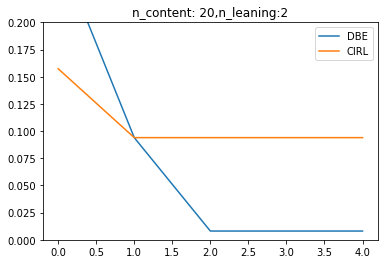

In [29]:
rewardDBE = []
for k in range(5):
    rbt1.learn(hm,mode = "DBE", verbose = False, cdt = cdt_list[k])
    rewardDBE.append(hm.reward(rbt1.action()))
    
rewardCIRL = []
for k in range(5):
    rbt2.learn(hm,mode = "CIRL", verbose = False, cdt = cdt_list[k])
    rewardCIRL.append(hm.reward(rbt2.action()))
    
plt.plot(rewardDBE, label = "DBE")
plt.plot(rewardCIRL, label = "CIRL")
plt.legend()
plt.title(f"n_content: {n_content},n_leaning:{n_learning}")
plt.axis(ymin = 0, ymax = 0.2)
plt.show()

## **Density estimation**

In [35]:
# Parameters for the learning
nb_est = 100 
epoch = 15
n_content = 20
n_learning = 8

# Parameters for the visualisation
min_y = 0
max_y = 0.1
min_x = 0
max_x = epoch - 1
dpi_y = 200
dpi_x = 20
pts_y = round((max_y - min_y)*dpi_y)
pts_x = round((max_x - min_y)*dpi_x)

# Parameters for the density estimation
sigma = 0.02
sigma_Ydpi = round(sigma * dpi_y)

In [36]:
# Generating the human
hm = [human() for k in range(nb_est)]

# Generating the robots
rbt0 = [robot(n_content = n_content) for k in range(nb_est)]
rbtDBE = [robot(content_ = rbt0[k].content.copy()) for k in range(nb_est)]
rbtCIRL = [robot(content_ = rbt0[k].content.copy()) for k in range(nb_est)]

# Generating the candidates
cdt_list = [[candidates(n_ = n_learning) for k in range(epoch)] for l in range(nb_est)]

In [37]:
# Creating the visualisations
gridDBE = np.zeros([pts_y, pts_x])
gridCIRL = np.zeros([pts_y, pts_x])

# Visualisation of the means
meanDBE = [0 for k in range(epoch)]
meanCIRL = [0 for k in range(epoch)]

In [38]:
# Utils
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def propagateGaussian(grid,x,y):
    """
    x corresponds to the INDEX of the point
    y corresponds to the VALUE of the value
    """
    y = round((y - min_y) * dpi_y)
    for k in range(pts_y):
        grid[pts_y-k-1,x] += gaussian(k, y, sigma_Ydpi)

def addLearning(grid, mean, rbt_, hm_, mode_, cdt_, verbose = False):
    reward_temp = []
    for k in range(epoch):
        rbt_.learn(hm_, mode = mode_, verbose = verbose, cdt = cdt_[k])
        reward_temp.append(hm_.reward(rbt_.action()))
        
    # Updating the mean
    for k in range(epoch):
        mean[k] += reward_temp[k]
        
    # Updating the grid
    for k in range(epoch - 1):
        for l in range(dpi_x):
            temp_y = reward_temp[k] + (reward_temp[k+1] - reward_temp[k])*(l/dpi_x)
            temp_x = k * dpi_x + l
            propagateGaussian(grid, temp_x, temp_y)
    

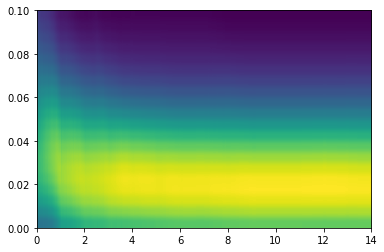

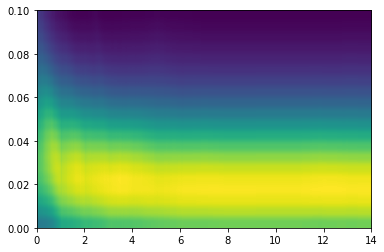

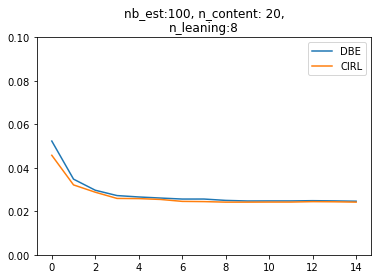

In [39]:
# DBE
for k in range(nb_est):
    addLearning(gridDBE, meanDBE, rbtDBE[k], hm[k], "DBE", cdt_list[k], verbose = False)
meanDBE = [meanDBE[k]/nb_est for k in range(epoch)]
    
plt.imshow(gridDBE, extent = [min_x , max_x, min_y , max_y], aspect='auto')
plt.show()


# CIRL
for k in range(nb_est):
    addLearning(gridCIRL, meanCIRL, rbtCIRL[k], hm[k], "CIRL", cdt_list[k], verbose = False)
meanCIRL = [meanCIRL[k]/nb_est for k in range(epoch)]
    
plt.imshow(gridCIRL, extent = [min_x , max_x, min_y , max_y], aspect='auto')
plt.show()

plt.plot(meanDBE, label = "DBE")
plt.plot(meanCIRL, label = "CIRL")
plt.axis(ymin = min_y, ymax = max_y)
plt.legend()
plt.title(f"nb_est:{nb_est}, n_content: {n_content},\nn_leaning:{n_learning}")
plt.show()